In [110]:
import os
import sys
import json
import keras
import torch
import pickle
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from collections import defaultdict
from keras.models import model_from_json
from matplotlib.ticker import MaxNLocator
from sklearn.model_selection import train_test_split

sys.path.append(str(Path().resolve().parent))

from src.data_loader import load_NMR_dataset
from src.arch import DeepEntropy

## Data

In [2]:
data_nmr = load_NMR_dataset(filter="moderate")
moderate_nmr_ids = [ele["ID"] for ele in data_nmr]

In [3]:
# loading embedding

nmr_data = torch.load(Path().resolve().parent / "data/embeddings/nmr_merged.pt")

nmr_embeddings = []
nmr_plddt = []
nmr_gscores = []
nmr_gscores_masks = []

for nmr_ele in nmr_data:
    if nmr_ele["ID"] in moderate_nmr_ids:
        emb = nmr_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(nmr_ele["plddt"], dtype=np.float32)  # shape: (L,)
        
        raw_gscores = nmr_ele["gscores"]
        mask = np.array([v is not None for v in raw_gscores], dtype=bool)
        cleaned_gscores = np.array([0.0 if v is None else v for v in raw_gscores], dtype=np.float32)

        if emb.shape[0] != plddt.shape[0] or emb.shape[0] != len(cleaned_gscores):
            print(f"Unmatching dimension!. Embedding dim: {emb.shape[0]} plddt dim: {plddt.shape[0]}")
            continue

        if sum(mask)/len(mask) > 0.8:
            nmr_embeddings.append(emb)
            nmr_plddt.append(plddt)
            nmr_gscores.append(cleaned_gscores)
            nmr_gscores_masks.append(mask)

In [4]:
print(len(nmr_embeddings))

627


In [5]:
disprot_data = torch.load(Path().resolve().parent / "data/embeddings/disprot_merged.pt")

disprot_embeddings = []
disprot_plddt = []
disprot_disorder_values = []

for idx, disprot_ele in enumerate(disprot_data):
    try:
        emb = disprot_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(disprot_ele["plddt"], dtype=np.float32)  # shape: (L,)
        disorder_value = np.array([disprot_ele["disorder_content"]], dtype=np.float32)  # scalar

        # Shape checks
        if emb.shape[0] != plddt.shape[0]:
            print(f"[{idx}] Shape mismatch: embedding L={emb.shape[0]}, plddt L={plddt.shape[0]}")
            continue
        if emb.shape[1] != 1024:
            print(f"[{idx}] Invalid embedding dim: got {emb.shape[1]}, expected 1024")
            continue
        
        disprot_embeddings.append(emb)
        disprot_plddt.append(plddt)
        disprot_disorder_values.append(disorder_value)

    except Exception as e:
        print(f"[{idx}] Error loading sample: {e}")

In [6]:
print(len(disprot_embeddings))

1620


In [7]:
softDis_data = torch.load(Path().resolve().parent / "data/embeddings/softdis_merged.pt")

softDis_embeddings = []
softDis_plddt = []
softDis_disorder_values = []

for idx, softDis_ele in enumerate(softDis_data):
    try:
        emb = softDis_ele["embedding"].numpy()  # shape: (L, 1024)
        plddt = np.array(softDis_ele["plddt"], dtype=np.float32)  # shape: (L,)
        disorder = np.array(softDis_ele["soft_disorder_frequency"], dtype=np.float32)  # shape: (L,)

        # Shape checks
        if emb.shape[1] != 1024:
            print(f"[{idx}] Invalid embedding dimension: got {emb.shape[1]}, expected 1024")
            continue
        if emb.shape[0] != plddt.shape[0] or emb.shape[0] != disorder.shape[0]:
            print(f"[{idx}] Length mismatch: embedding L={emb.shape[0]}, plddt L={plddt.shape[0]}, disorder L={disorder.shape[0]}")
            continue

        softDis_embeddings.append(emb)
        softDis_plddt.append(plddt)
        softDis_disorder_values.append(disorder)

    except Exception as e:
        print(f"[{idx}] Error loading sample: {e}")

[1714] Length mismatch: embedding L=1038, plddt L=1033, disorder L=1038
[2755] Length mismatch: embedding L=549, plddt L=571, disorder L=549
[2981] Length mismatch: embedding L=644, plddt L=645, disorder L=644
[3650] Length mismatch: embedding L=488, plddt L=221, disorder L=488


In [8]:
print(len(softDis_embeddings))

4068


## Train-Validation-Test data Split

In [9]:

disprot_masks = [np.ones_like(plddt, dtype=bool) for plddt in disprot_plddt]
softDis_masks = [np.ones_like(plddt, dtype=bool) for plddt in softDis_plddt]
combined_data = []

for idx in range(len(nmr_embeddings)):
    combined_data.append((
        nmr_embeddings[idx],
        nmr_plddt[idx] / 100,
        nmr_gscores[idx],
        nmr_gscores_masks[idx],
        "g_scores"
    ))

for idx in range(len(disprot_embeddings)):
    combined_data.append((
        disprot_embeddings[idx],
        disprot_plddt[idx] / 100,
        disprot_disorder_values[idx],
        disprot_masks[idx],
        "disprot_disorder"
    ))

for idx in range(len(softDis_embeddings)):
    combined_data.append((
        softDis_embeddings[idx],
        softDis_plddt[idx] / 100,
        softDis_disorder_values[idx],
        softDis_masks[idx],
        "softdis_disorder"
    ))

random.seed(42)
random.shuffle(combined_data)


In [10]:
labels = [entry[-1] for entry in combined_data]

train_val, test_data = train_test_split(
    combined_data,
    test_size=0.10,
    random_state=42,
    stratify=labels
)

train_data, val_data = train_test_split(
    train_val,
    test_size=2/9,
    random_state=42,
    stratify=[entry[-1] for entry in train_val]
)

print(f"total: {len(combined_data)}")
print(f"train: {len(train_data)} ({len(train_data)/len(combined_data):.2%})")
print(f"val: {len(val_data)} ({len(val_data)/len(combined_data):.2%})")
print(f"test: {len(test_data)} ({len(test_data)/len(combined_data):.2%})")

total: 6315
train: 4420 (69.99%)
val: 1263 (20.00%)
test: 632 (10.01%)


## Loading Model Weights

In [11]:
dir_path = f"{str(Path().resolve().parent)}/data/models/2025_06_23_21_53_41_mse_ln_dropout_no_encoder_100"

In [12]:
with open(os.path.join(dir_path, "encoder.json"), 'r') as json_file:
    encoder_json = json_file.read()
encoder = model_from_json(encoder_json)

with open(os.path.join(dir_path, "nmr_head.json"), 'r') as json_file:
    nmr_head_json = json_file.read()
nmr_head = model_from_json(nmr_head_json)

with open(os.path.join(dir_path, "disprot_head.json"), 'r') as json_file:
    disprot_head_json = json_file.read()
disprot_head = model_from_json(disprot_head_json)

with open(os.path.join(dir_path, "softdis_head.json"), 'r') as json_file:
    softdis_head_json = json_file.read()
softdis_head = model_from_json(softdis_head_json)

In [13]:
entropy = DeepEntropy(
    encoder_model = encoder, 
    nmr_head = nmr_head, 
    disProt_head = disprot_head, 
    softDis_head = softdis_head
)

In [14]:
LEARNING_RATE = 0.001
entropy.compile(
    NMR_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    DisProt_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    SoftDis_optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    NMR_head_loss_fn = keras.losses.MeanSquaredError(),
    DisProt_head_loss_fn = keras.losses.MeanSquaredError(),
    SoftDis_head_loss_fn = keras.losses.MeanSquaredError()
)
entropy.run_eagerly = True

In [15]:
input_embeddings, input_plddt, _, _, _ = train_data[0]
entropy.build_init(
    embedding_shape = (1, input_embeddings.shape[0], input_embeddings.shape[1]), 
    plddt_shape = (1, input_plddt.shape[0],),
    encoded_data_dim = 1025
)

All the heads and optimizers are initialized. Good luck with the training loop!


In [16]:
entropy.encoder.load_weights(os.path.join(dir_path, "encoder.weights.h5"))
entropy.nmr_head_model.load_weights(os.path.join(dir_path, "nmr_head.weights.h5"))
entropy.DisProt_head_model.load_weights(os.path.join(dir_path, "disProt_head.weights.h5"))
entropy.softdis_head_model.load_weights(os.path.join(dir_path, "softDis_head.weights.h5"))

## Pearson correlation & MSE : Train Set

In [17]:
def predict(model, data):
    (input_embeddings, input_plddt) = data
    combined_features = model.encoder([input_embeddings, input_plddt])

    if model.target_flag_ == "g_scores":
        return model.nmr_head_model(combined_features)
    elif model.target_flag_ == "disprot_disorder":
        return model.DisProt_head_model(combined_features)
    else:
        return model.softdis_head_model(combined_features)

In [144]:
r_nmr_values = []
r_softDis_values = []
nmr_losses = []
disprot_losses = []
softdis_losses = []

for input_embeddings, input_plddt, target, mask, task_flag in train_data:
    entropy.target_flag_ = task_flag

    input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
    input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
    target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)

    data = (input_embeddings_tf, input_plddt_tf)
    prediction = predict(entropy, data)


    if task_flag == "g_scores":
        loss = entropy.NMR_head_loss_fn(target_tf, prediction)
        nmr_losses.append(loss)
        r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))
        r_nmr_values.append(r)

    elif task_flag == "disprot_disorder":
        loss = entropy.DisProt_head_loss_fn(target_tf, prediction)
        disprot_losses.append(loss)

    else:
        loss = entropy.SoftDis_head_loss_fn(target_tf, prediction)
        softdis_losses.append(loss)
        r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))
        r_softDis_values.append(r)
    

C:\Users\panth\AppData\Local\Temp\ipykernel_15912\2232087042.py:31: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))


In [145]:
r_nmr_values = np.array(r_nmr_values)
mean_r_nmr = np.mean(r_nmr_values)
std_r_nmr  = np.std(r_nmr_values, ddof=1)

r_softDis_values = np.array(r_softDis_values)
r_softDis_values = r_softDis_values[~np.isnan(r_softDis_values)]
mean_r_softDis = np.mean(r_softDis_values)
std_r_softDis  = np.std(r_softDis_values, ddof=1)

print(f"Per-protein Pearson's r: mean = {mean_r_nmr:.3f}, std = {std_r_nmr:.3f}")
print(f"Per-protein Pearson's r: mean = {mean_r_softDis:.3f}, std = {std_r_softDis:.3f}")

Per-protein Pearson's r: mean = 0.840, std = 0.172
Per-protein Pearson's r: mean = 0.688, std = 0.164


In [147]:
dir_path_evaluation = Path(dir_path) / "evaluation"
os.makedirs(dir_path_evaluation, exist_ok=True)

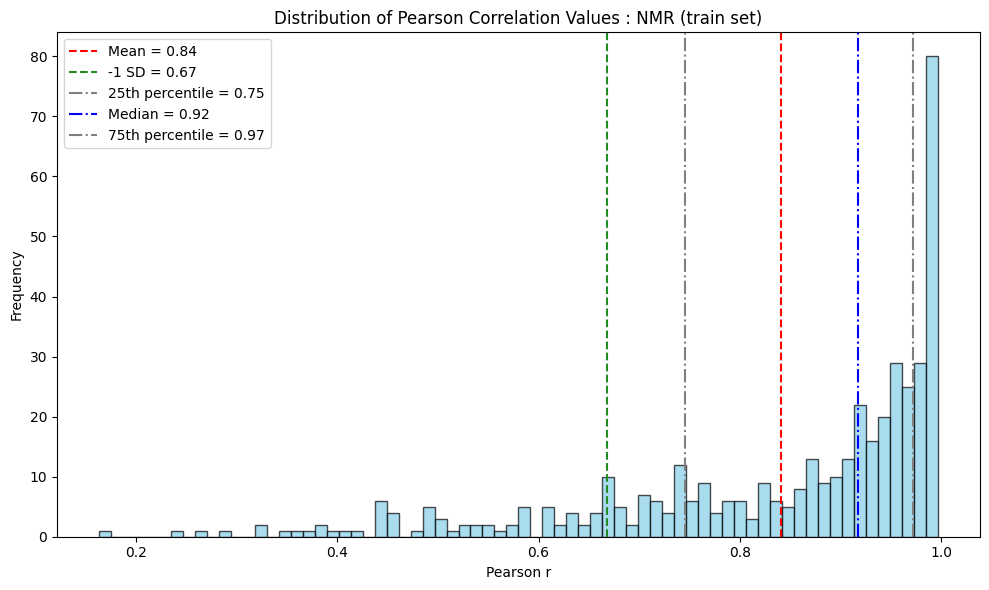

In [148]:
mean_r = np.mean(r_nmr_values)
std_r = np.std(r_nmr_values, ddof=1)

q25, q50, q75 = np.percentile(r_nmr_values, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(r_nmr_values, bins=70, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_r, color='red', linestyle='--', label=f'Mean = {mean_r:.2f}')
# plt.axvline(mean_r + std_r, color='#228B22', linestyle='--', label=f'+1 SD = {mean_r + std_r:.2f}')
plt.axvline(mean_r - std_r, color='#228B22', linestyle='--', label=f'-1 SD = {mean_r - std_r:.2f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.2f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.2f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.2f}')

plt.title("Distribution of Pearson Correlation Values : NMR (train set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_pearson_r_nmr_train.png"))
plt.show()

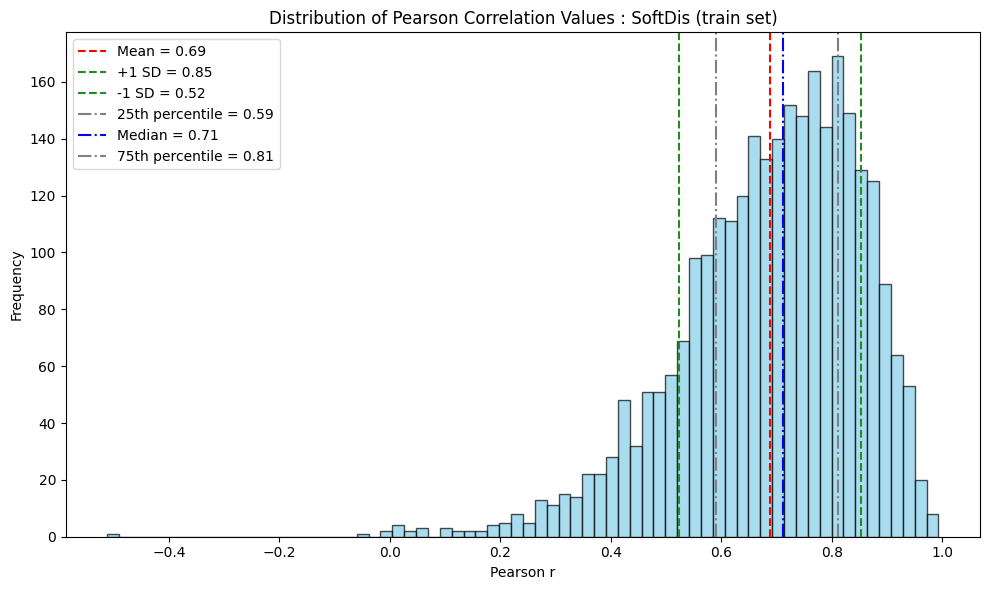

In [149]:
mean_r = np.mean(r_softDis_values)
std_r = np.std(r_softDis_values, ddof=1)

q25, q50, q75 = np.percentile(r_softDis_values, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(r_softDis_values, bins=70, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_r, color='red', linestyle='--', label=f'Mean = {mean_r:.2f}')
plt.axvline(mean_r + std_r, color='#228B22', linestyle='--', label=f'+1 SD = {mean_r + std_r:.2f}')
plt.axvline(mean_r - std_r, color='#228B22', linestyle='--', label=f'-1 SD = {mean_r - std_r:.2f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.2f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.2f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.2f}')

plt.title("Distribution of Pearson Correlation Values : SoftDis (train set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_pearson_r_sofDis_train.png"))
plt.show()

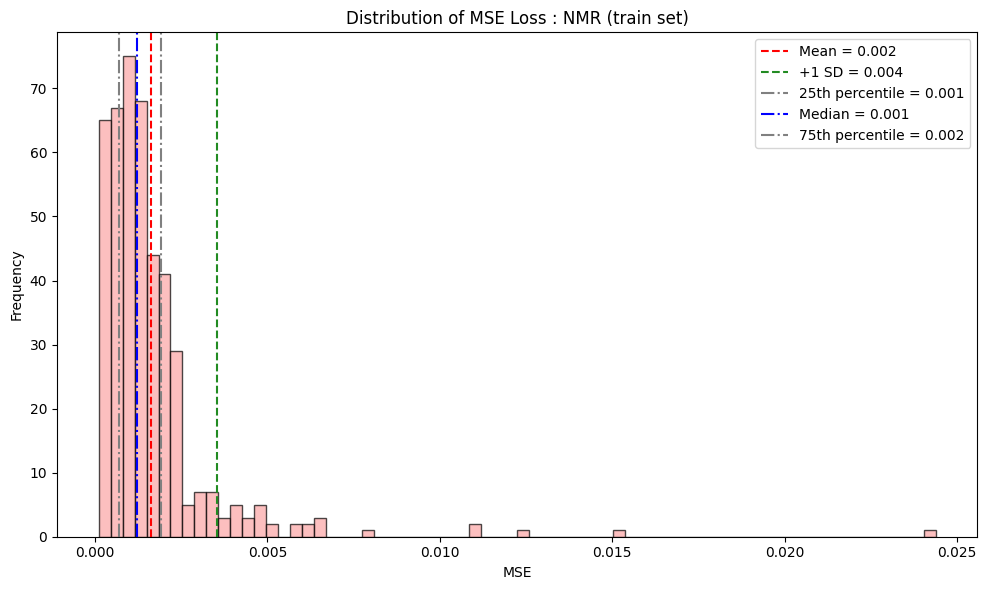

In [150]:
mean_mse = np.mean(nmr_losses)
std_mse = np.std(nmr_losses, ddof=1)
q25, q50, q75 = np.percentile(nmr_losses, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(nmr_losses, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean = {mean_mse:.3f}')
plt.axvline(mean_mse + std_mse, color='#228B22', linestyle='--', label=f'+1 SD = {mean_mse + std_mse:.3f}')
plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.3f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.3f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.3f}')

plt.title("Distribution of MSE Loss : NMR (train set)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_mse_nmr_train.png"))
plt.show()


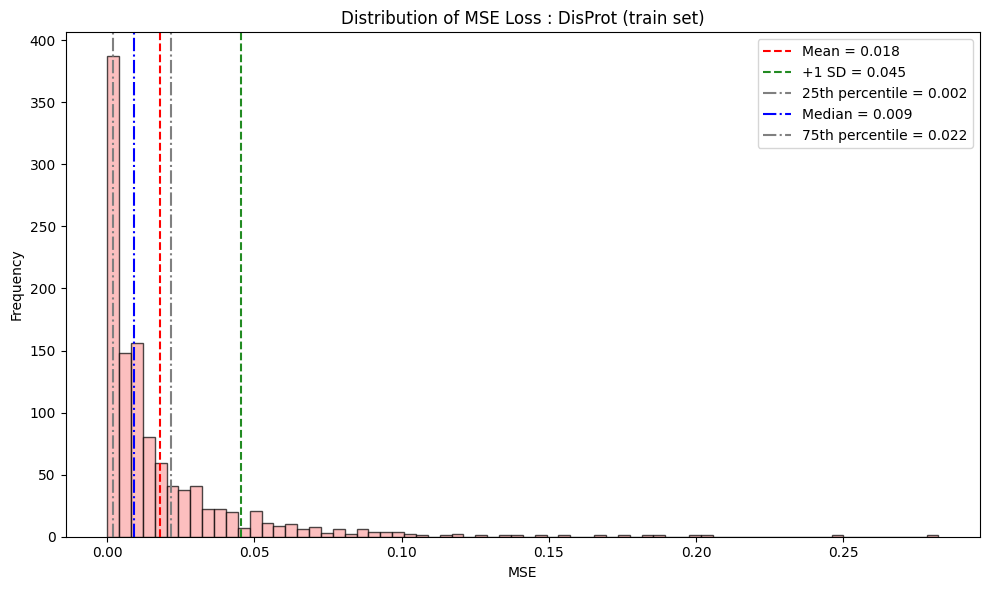

In [151]:
mean_mse = np.mean(disprot_losses)
std_mse = np.std(disprot_losses, ddof=1)
q25, q50, q75 = np.percentile(disprot_losses, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(disprot_losses, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean = {mean_mse:.3f}')
plt.axvline(mean_mse + std_mse, color='#228B22', linestyle='--', label=f'+1 SD = {mean_mse + std_mse:.3f}')
plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.3f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.3f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.3f}')

plt.title("Distribution of MSE Loss : DisProt (train set)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_mse_disProt_train.png"))
plt.show()


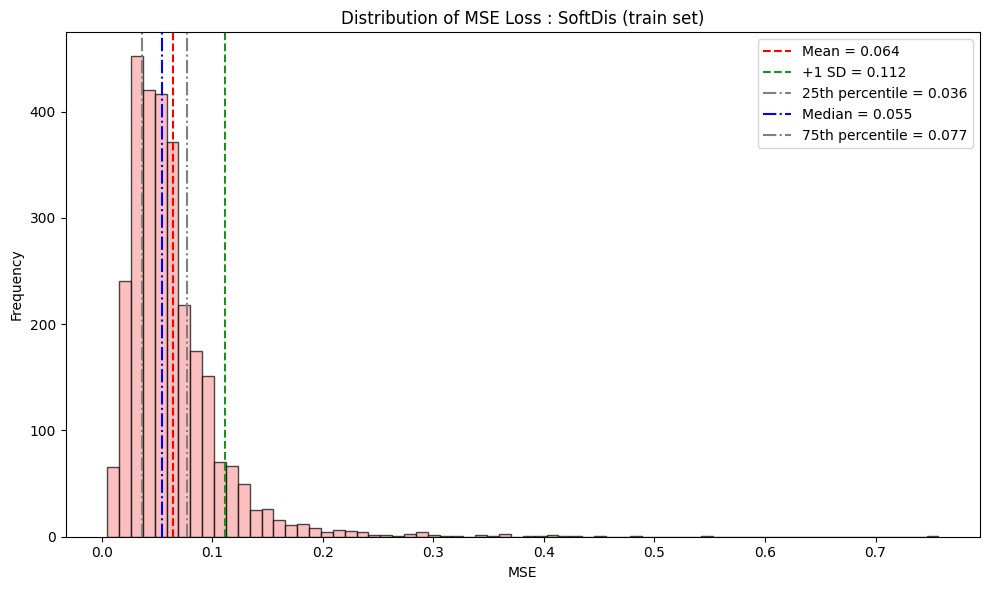

In [152]:
mean_mse = np.mean(softdis_losses)
std_mse = np.std(softdis_losses, ddof=1)
q25, q50, q75 = np.percentile(softdis_losses, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(softdis_losses, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean = {mean_mse:.3f}')
plt.axvline(mean_mse + std_mse, color='#228B22', linestyle='--', label=f'+1 SD = {mean_mse + std_mse:.3f}')
plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.3f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.3f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.3f}')

plt.title("Distribution of MSE Loss : SoftDis (train set)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_mse_SoftDis_train.png"))
plt.show()


## Pearson correlation & MSE : Validation Set

In [153]:
r_nmr_values = []
r_softDis_values = []
nmr_losses = []
disprot_losses = []
softdis_losses = []

for input_embeddings, input_plddt, target, mask, task_flag in val_data:
    entropy.target_flag_ = task_flag

    input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
    input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
    target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)

    data = (input_embeddings_tf, input_plddt_tf)
    prediction = predict(entropy, data)


    if task_flag == "g_scores":
        loss = entropy.NMR_head_loss_fn(target_tf, prediction)
        nmr_losses.append(loss)
        r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))
        r_nmr_values.append(r)

    elif task_flag == "disprot_disorder":
        loss = entropy.DisProt_head_loss_fn(target_tf, prediction)
        disprot_losses.append(loss)

    else:
        loss = entropy.SoftDis_head_loss_fn(target_tf, prediction)
        softdis_losses.append(loss)
        r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))
        r_softDis_values.append(r)
    

In [154]:
r_nmr_values = np.array(r_nmr_values)
mean_r_nmr = np.mean(r_nmr_values)
std_r_nmr  = np.std(r_nmr_values, ddof=1)

r_softDis_values = np.array(r_softDis_values)
r_softDis_values = r_softDis_values[~np.isnan(r_softDis_values)]
mean_r_softDis = np.mean(r_softDis_values)
std_r_softDis  = np.std(r_softDis_values, ddof=1)

print(f"Per-protein Pearson's r: mean = {mean_r_nmr:.3f}, std = {std_r_nmr:.3f}")
print(f"Per-protein Pearson's r: mean = {mean_r_softDis:.3f}, std = {std_r_softDis:.3f}")

Per-protein Pearson's r: mean = 0.583, std = 0.323
Per-protein Pearson's r: mean = 0.615, std = 0.184


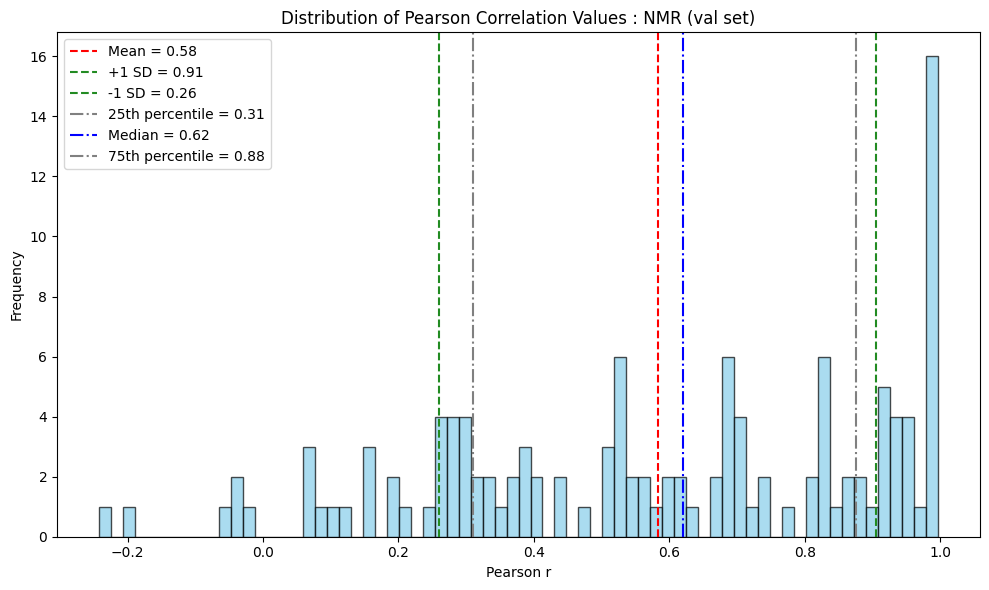

In [155]:
mean_r = np.mean(r_nmr_values)
std_r = np.std(r_nmr_values, ddof=1)

q25, q50, q75 = np.percentile(r_nmr_values, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(r_nmr_values, bins=70, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_r, color='red', linestyle='--', label=f'Mean = {mean_r:.2f}')
plt.axvline(mean_r + std_r, color='#228B22', linestyle='--', label=f'+1 SD = {mean_r + std_r:.2f}')
plt.axvline(mean_r - std_r, color='#228B22', linestyle='--', label=f'-1 SD = {mean_r - std_r:.2f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.2f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.2f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.2f}')

plt.title("Distribution of Pearson Correlation Values : NMR (val set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_pearson_r_nmr_val.png"))
plt.show()

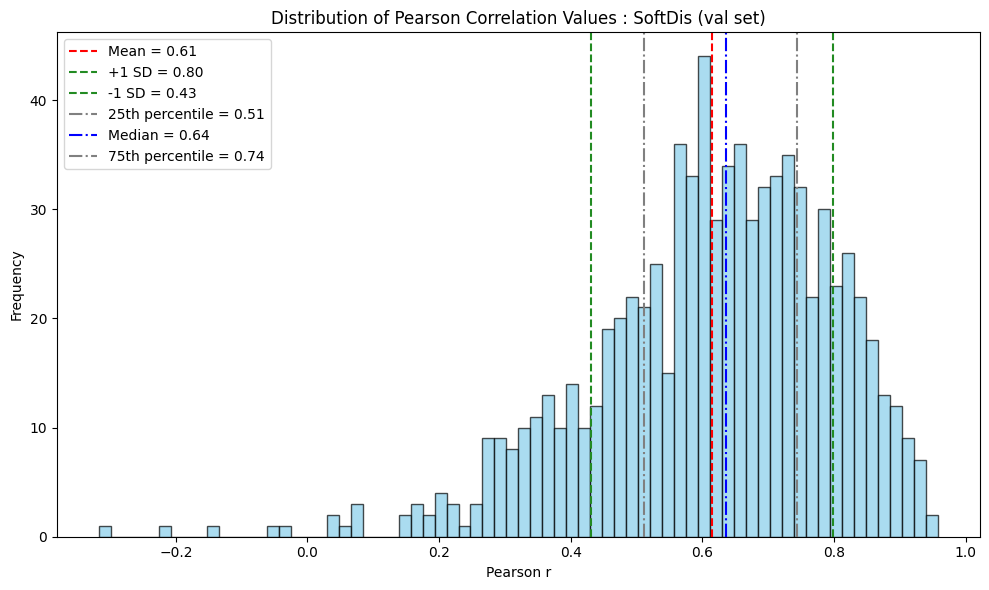

In [156]:
mean_r = np.mean(r_softDis_values)
std_r = np.std(r_softDis_values, ddof=1)

q25, q50, q75 = np.percentile(r_softDis_values, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(r_softDis_values, bins=70, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean_r, color='red', linestyle='--', label=f'Mean = {mean_r:.2f}')
plt.axvline(mean_r + std_r, color='#228B22', linestyle='--', label=f'+1 SD = {mean_r + std_r:.2f}')
plt.axvline(mean_r - std_r, color='#228B22', linestyle='--', label=f'-1 SD = {mean_r - std_r:.2f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.2f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.2f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.2f}')

plt.title("Distribution of Pearson Correlation Values : SoftDis (val set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_pearson_r_softDis_val.png"))
plt.show()

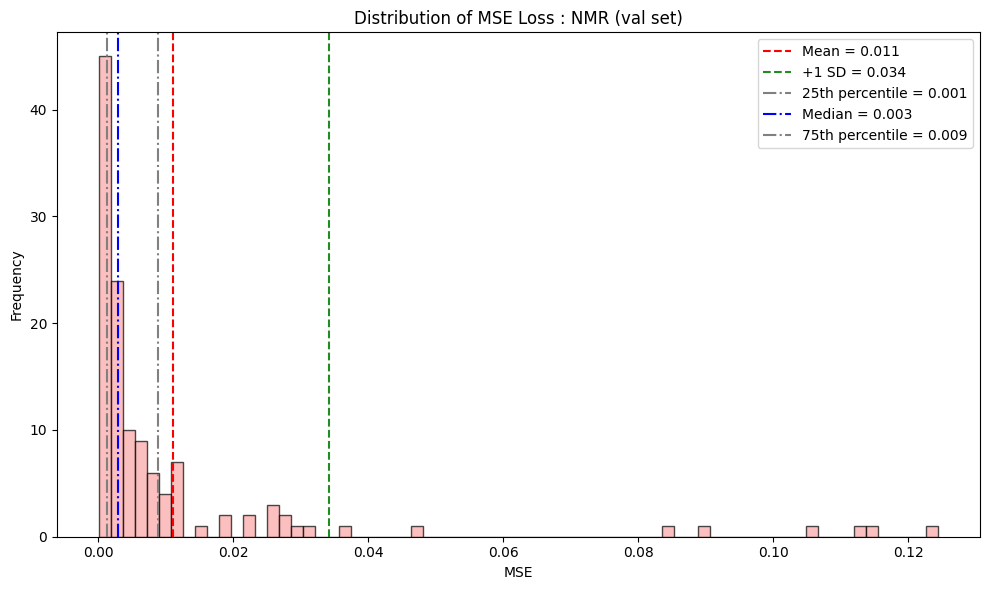

In [157]:
mean_mse = np.mean(nmr_losses)
std_mse = np.std(nmr_losses, ddof=1)
q25, q50, q75 = np.percentile(nmr_losses, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(nmr_losses, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean = {mean_mse:.3f}')
plt.axvline(mean_mse + std_mse, color='#228B22', linestyle='--', label=f'+1 SD = {mean_mse + std_mse:.3f}')
plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.3f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.3f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.3f}')

plt.title("Distribution of MSE Loss : NMR (val set)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_mse_nmr_val.png"))
plt.show()


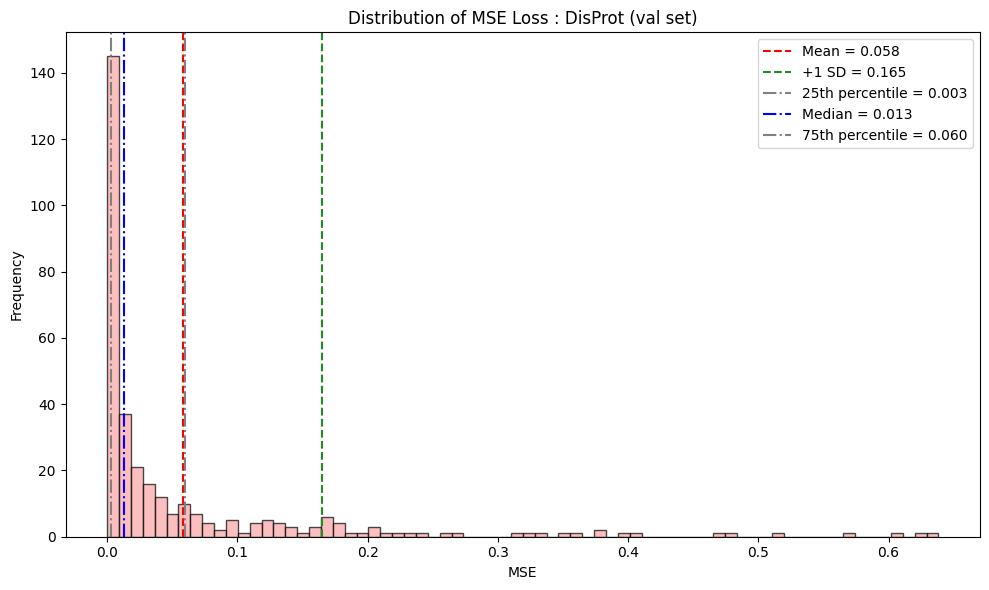

In [158]:
mean_mse = np.mean(disprot_losses)
std_mse = np.std(disprot_losses, ddof=1)
q25, q50, q75 = np.percentile(disprot_losses, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(disprot_losses, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean = {mean_mse:.3f}')
plt.axvline(mean_mse + std_mse, color='#228B22', linestyle='--', label=f'+1 SD = {mean_mse + std_mse:.3f}')
plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.3f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.3f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.3f}')

plt.title("Distribution of MSE Loss : DisProt (val set)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_mse_disProt_val.png"))
plt.show()


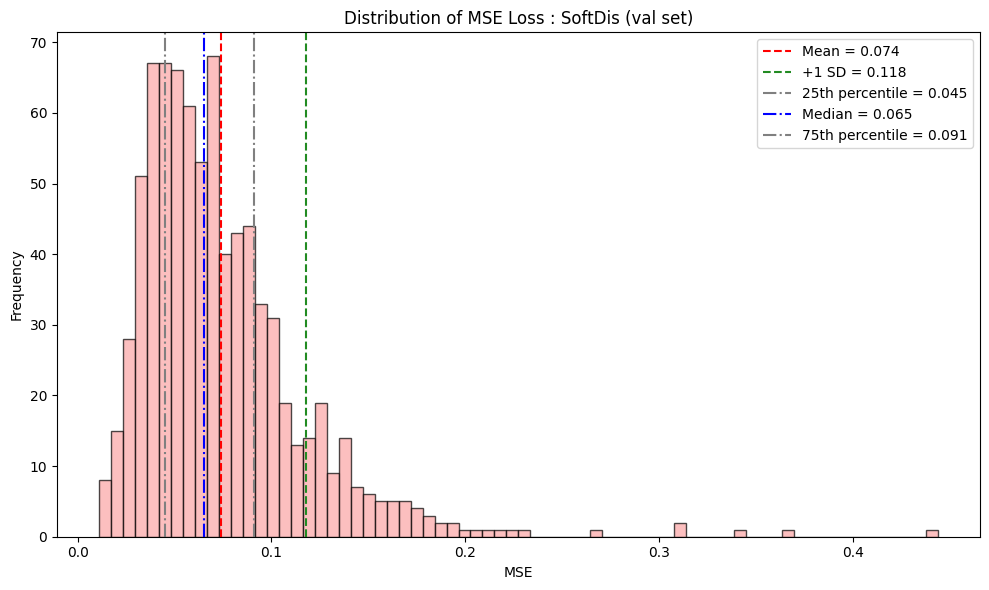

In [159]:
mean_mse = np.mean(softdis_losses)
std_mse = np.std(softdis_losses, ddof=1)
q25, q50, q75 = np.percentile(softdis_losses, [25, 50, 75])

plt.figure(figsize=(10, 6))
plt.hist(softdis_losses, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='--', label=f'Mean = {mean_mse:.3f}')
plt.axvline(mean_mse + std_mse, color='#228B22', linestyle='--', label=f'+1 SD = {mean_mse + std_mse:.3f}')
plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.3f}')
plt.axvline(q50, color='blue', linestyle='-.', label=f'Median = {q50:.3f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.3f}')

plt.title("Distribution of MSE Loss : SoftDis (val set)")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_mse_softDis_val.png"))
plt.show()


## Pearson correlation & MSE : Test Set

In [111]:
task_data_dict = defaultdict(list)
for entry in train_data:
    task_data_dict[entry[-1]].append(entry)

In [116]:
r_nmr_values_all = []
r_softDis_values_all = []
nmr_losses_all = []
disprot_losses_all = []
softdis_losses_all = []

for i in range(1000):
    r_nmr_values = []
    r_softDis_values = []
    nmr_losses = []
    disprot_losses = []
    softdis_losses = []

    with open(Path().resolve().parent / f"data/bootstrap_test_sets/g_scores/indices_{i}.pkl", "rb") as f:
        g_scores_indices = pickle.load(f)
    g_scores_sampled_data = [task_data_dict["g_scores"][i] for i in g_scores_indices]

    with open(Path().resolve().parent / f"data/bootstrap_test_sets/disprot_disorder/indices_{i}.pkl", "rb") as f:
        disprot_disorder_indices = pickle.load(f)
    disprot_disorder_sampled_data = [task_data_dict["disprot_disorder"][i] for i in disprot_disorder_indices]

    with open(Path().resolve().parent / f"data/bootstrap_test_sets/softdis_disorder/indices_{i}.pkl", "rb") as f:
        softdis_disorder_indices = pickle.load(f)
    softdis_disorder_sampled_data = [task_data_dict["softdis_disorder"][i] for i in softdis_disorder_indices]

    merged = g_scores_sampled_data + disprot_disorder_sampled_data + softdis_disorder_sampled_data
    for input_embeddings, input_plddt, target, mask, task_flag in merged:
        entropy.target_flag_ = task_flag

        input_embeddings_tf = tf.convert_to_tensor(input_embeddings[np.newaxis, ...], dtype=tf.float32)
        input_plddt_tf = tf.convert_to_tensor(input_plddt[np.newaxis, ...], dtype=tf.float32)
        target_tf = tf.convert_to_tensor(target[np.newaxis, ...], dtype=tf.float32)

        data = (input_embeddings_tf, input_plddt_tf)
        prediction = predict(entropy, data)


        if task_flag == "g_scores":
            loss = entropy.NMR_head_loss_fn(target_tf, prediction)
            nmr_losses.append(loss)
            r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))
            r_nmr_values.append(r)

        elif task_flag == "disprot_disorder":
            loss = entropy.DisProt_head_loss_fn(target_tf, prediction)
            disprot_losses.append(loss)

        else:
            loss = entropy.SoftDis_head_loss_fn(target_tf, prediction)
            softdis_losses.append(loss)
            r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))
            r_softDis_values.append(r)

    r_nmr_values_all.append(r_nmr_values)
    r_softDis_values_all.append(r_softDis_values)
    nmr_losses_all.append(nmr_losses)
    disprot_losses_all.append(disprot_losses)
    softdis_losses_all.append(softdis_losses)
        

C:\Users\panth\AppData\Local\Temp\ipykernel_15912\1490530993.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(target.reshape((target.shape[0])), prediction.numpy().reshape((target.shape[0])))


In [120]:
bootstrap_r_nmr_values_all = np.array(r_nmr_values_all).mean(axis=1)
bootstrap_r_softDis_values_all = np.array(r_softDis_values_all).mean(axis=1)
bootstrap_nmr_losses_all = np.array(nmr_losses_all).mean(axis=1)
bootstrap_disprot_losses_all = np.array(disprot_losses_all).mean(axis=1)
bootstrap_softdis_losses_all = np.array(softdis_losses_all).mean(axis=1)

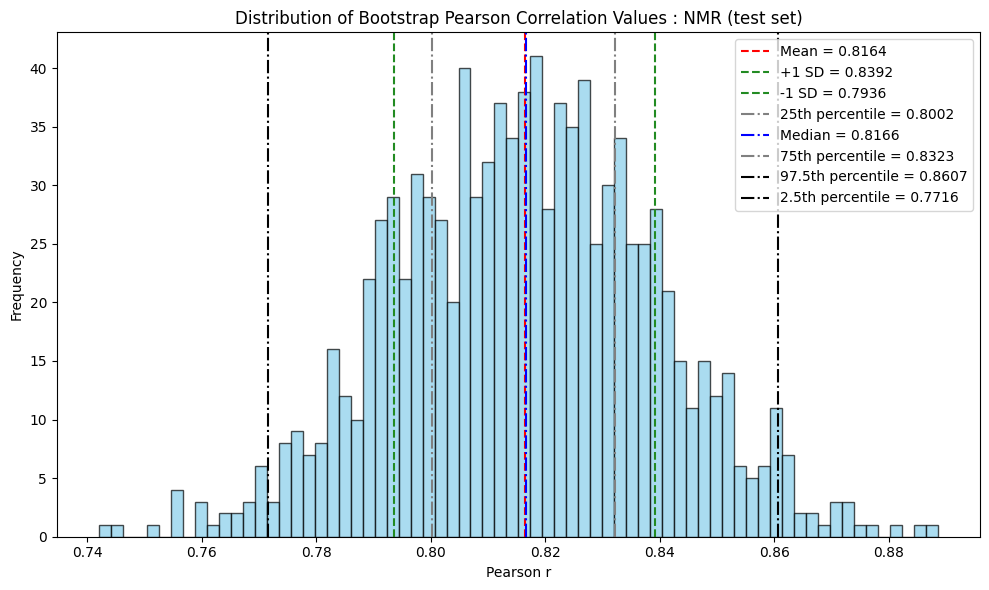

In [ ]:
mean = np.mean(bootstrap_r_nmr_values_all)
std = np.std(bootstrap_r_nmr_values_all, ddof=1)
median = np.median(bootstrap_r_nmr_values_all)
q25, q75 = np.percentile(bootstrap_r_nmr_values_all, [25, 75])
lower = np.percentile(bootstrap_r_nmr_values_all, 2.5)
upper = np.percentile(bootstrap_r_nmr_values_all, 97.5)


plt.figure(figsize=(10, 6))
plt.hist(bootstrap_r_nmr_values_all, bins=70, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')
plt.axvline(mean + std, color='#228B22', linestyle='--', label=f'+1 SD = {mean + std:.4f}')
plt.axvline(mean - std, color='#228B22', linestyle='--', label=f'-1 SD = {mean - std:.4f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.4f}')
plt.axvline(median, color='blue', linestyle='-.', label=f'Median = {median:.4f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.4f}')
plt.axvline(upper, color='black', linestyle='-.', label=f'97.5th percentile = {upper:.4f}')
plt.axvline(lower, color='black', linestyle='-.', label=f'2.5th percentile = {lower:.4f}')

plt.title("Distribution of Bootstrap Pearson Correlation Values : NMR (test set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_bootstrap_pearson_r_nmr_test.png"))
plt.show()

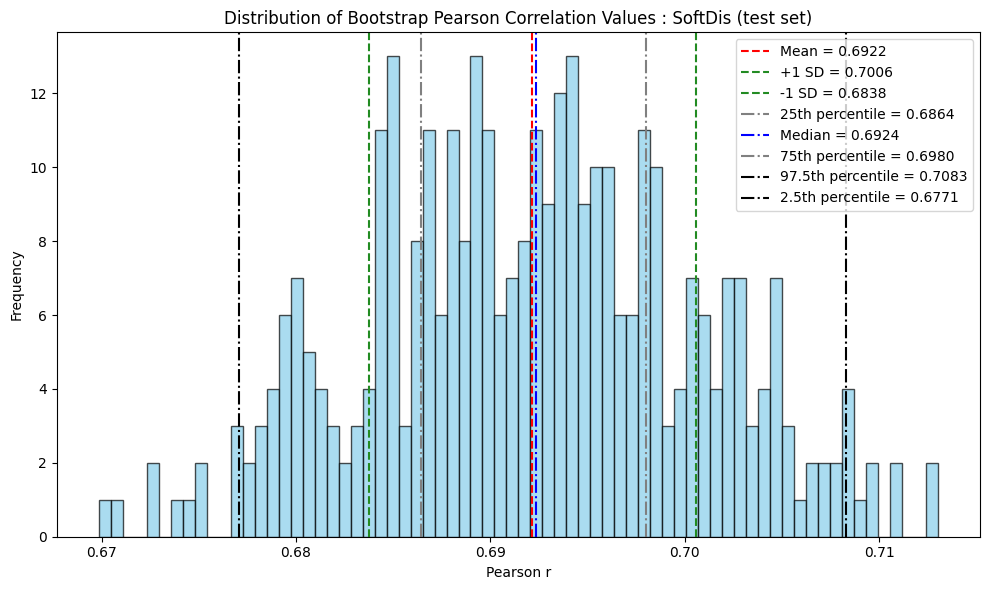

In [ ]:
bootstrap_r_softDis_values_all = bootstrap_r_softDis_values_all[~np.isnan(bootstrap_r_softDis_values_all)]
mean = np.mean(bootstrap_r_softDis_values_all)
std = np.std(bootstrap_r_softDis_values_all, ddof=1)
median = np.median(bootstrap_r_softDis_values_all)
q25, q75 = np.percentile(bootstrap_r_softDis_values_all, [25, 75])
lower = np.percentile(bootstrap_r_softDis_values_all, 2.5)
upper = np.percentile(bootstrap_r_softDis_values_all, 97.5)


plt.figure(figsize=(10, 6))
plt.hist(bootstrap_r_softDis_values_all, bins=70, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')
plt.axvline(mean + std, color='#228B22', linestyle='--', label=f'+1 SD = {mean + std:.4f}')
plt.axvline(mean - std, color='#228B22', linestyle='--', label=f'-1 SD = {mean - std:.4f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.4f}')
plt.axvline(median, color='blue', linestyle='-.', label=f'Median = {median:.4f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.4f}')
plt.axvline(upper, color='black', linestyle='-.', label=f'97.5th percentile = {upper:.4f}')
plt.axvline(lower, color='black', linestyle='-.', label=f'2.5th percentile = {lower:.4f}')

plt.title("Distribution of Bootstrap Pearson Correlation Values : SoftDis (test set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_bootstrap_pearson_r_softDis_test.png"))
plt.show()

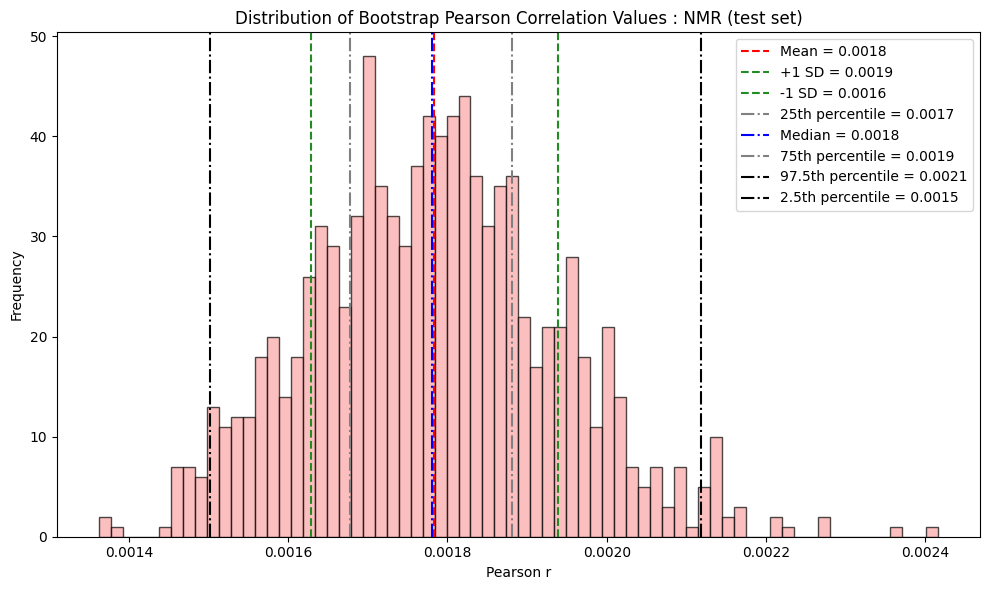

In [ ]:
mean = np.mean(bootstrap_nmr_losses_all)
std = np.std(bootstrap_nmr_losses_all, ddof=1)
median = np.median(bootstrap_nmr_losses_all)
q25, q75 = np.percentile(bootstrap_nmr_losses_all, [25, 75])
lower = np.percentile(bootstrap_nmr_losses_all, 2.5)
upper = np.percentile(bootstrap_nmr_losses_all, 97.5)


plt.figure(figsize=(10, 6))
plt.hist(bootstrap_nmr_losses_all, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')
plt.axvline(mean + std, color='#228B22', linestyle='--', label=f'+1 SD = {mean + std:.4f}')
plt.axvline(mean - std, color='#228B22', linestyle='--', label=f'-1 SD = {mean - std:.4f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.4f}')
plt.axvline(median, color='blue', linestyle='-.', label=f'Median = {median:.4f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.4f}')
plt.axvline(upper, color='black', linestyle='-.', label=f'97.5th percentile = {upper:.4f}')
plt.axvline(lower, color='black', linestyle='-.', label=f'2.5th percentile = {lower:.4f}')

plt.title("Distribution of Bootstrap Pearson Correlation Values : NMR (test set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_bootstrap_mse_nmr_test.png"))
plt.show()


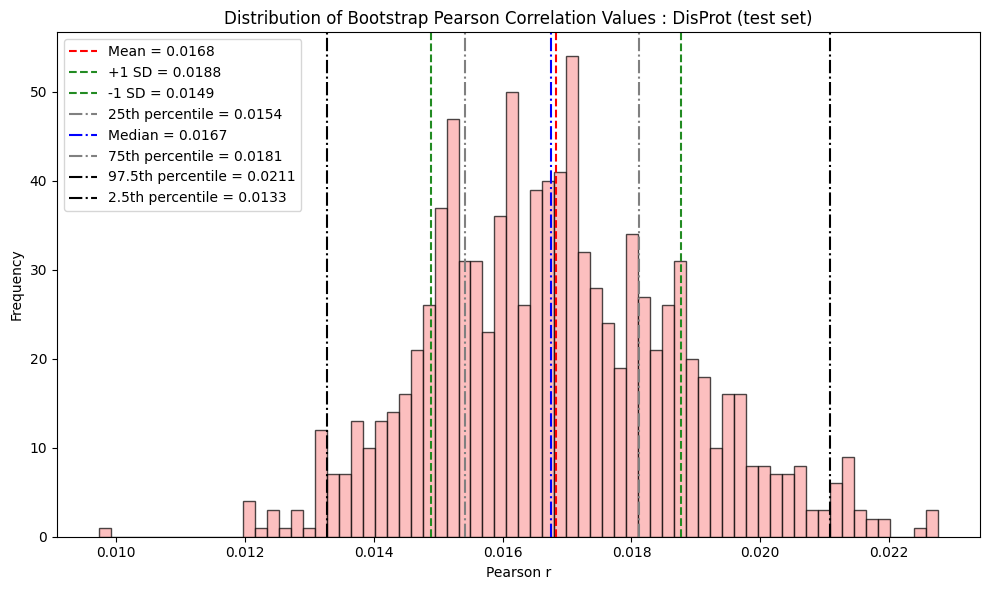

In [ ]:
mean = np.mean(bootstrap_disprot_losses_all)
std = np.std(bootstrap_disprot_losses_all, ddof=1)
median = np.median(bootstrap_disprot_losses_all)
q25, q75 = np.percentile(bootstrap_disprot_losses_all, [25, 75])
lower = np.percentile(bootstrap_disprot_losses_all, 2.5)
upper = np.percentile(bootstrap_disprot_losses_all, 97.5)


plt.figure(figsize=(10, 6))
plt.hist(bootstrap_disprot_losses_all, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')
plt.axvline(mean + std, color='#228B22', linestyle='--', label=f'+1 SD = {mean + std:.4f}')
plt.axvline(mean - std, color='#228B22', linestyle='--', label=f'-1 SD = {mean - std:.4f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.4f}')
plt.axvline(median, color='blue', linestyle='-.', label=f'Median = {median:.4f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.4f}')
plt.axvline(upper, color='black', linestyle='-.', label=f'97.5th percentile = {upper:.4f}')
plt.axvline(lower, color='black', linestyle='-.', label=f'2.5th percentile = {lower:.4f}')

plt.title("Distribution of Bootstrap Pearson Correlation Values : DisProt (test set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_bootstrap_mse_disProt_test.png"))
plt.show()


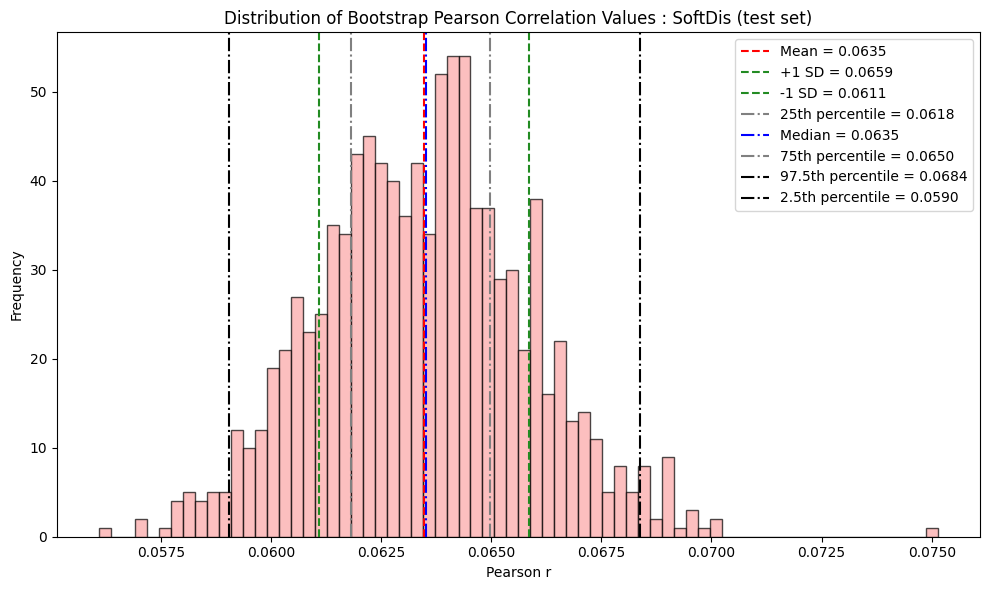

In [ ]:
mean = np.mean(bootstrap_softdis_losses_all)
std = np.std(bootstrap_softdis_losses_all, ddof=1)
median = np.median(bootstrap_softdis_losses_all)
q25, q75 = np.percentile(bootstrap_softdis_losses_all, [25, 75])
lower = np.percentile(bootstrap_softdis_losses_all, 2.5)
upper = np.percentile(bootstrap_softdis_losses_all, 97.5)


plt.figure(figsize=(10, 6))
plt.hist(bootstrap_softdis_losses_all, bins=70, color='#fca5a5', edgecolor='black', alpha=0.7)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.4f}')
plt.axvline(mean + std, color='#228B22', linestyle='--', label=f'+1 SD = {mean + std:.4f}')
plt.axvline(mean - std, color='#228B22', linestyle='--', label=f'-1 SD = {mean - std:.4f}')

plt.axvline(q25, color='gray', linestyle='-.', label=f'25th percentile = {q25:.4f}')
plt.axvline(median, color='blue', linestyle='-.', label=f'Median = {median:.4f}')
plt.axvline(q75, color='gray', linestyle='-.', label=f'75th percentile = {q75:.4f}')
plt.axvline(upper, color='black', linestyle='-.', label=f'97.5th percentile = {upper:.4f}')
plt.axvline(lower, color='black', linestyle='-.', label=f'2.5th percentile = {lower:.4f}')

plt.title("Distribution of Bootstrap Pearson Correlation Values : SoftDis (test set)")
plt.xlabel("Pearson r")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dir_path_evaluation, "dist_bootstrap_mse_softDis_test.png"))
plt.show()
